Load deepcell and utilities

In [1]:
import tifffile
from deepcell.applications import CytoplasmSegmentation, NuclearSegmentation, Mesmer
import matplotlib.pyplot as plt
import numpy as np

## Data

DeepCell does not provide any tools for opening images on its own. Instead, this environment (when loaded from the provided YAML) includes packages for handling image loading including pillow, opencv, and tifffile. For the purpose of this example, we have opted to use tifffile.

In [2]:
image = tifffile.imread('MAX_registered time points-1.tif')
image.shape

(98, 2, 368, 341)

DeepCell expects images to come in the shape [B,X,Y,C] where B = batch. This image comes in the shape [T,C,X,Y] which means a simple permute can allow us to use DeepCell's pretrained models.

In [3]:
image = np.transpose(image, (0,2,3,1))
image.shape

(98, 368, 341, 2)

Rather than treating this image as batches - which is what would happen if we don't index into `collagen_image` - we will look at just one time stamp and treat it as one batched image. To make sure we still keep the 4 dimensions as specified earlier, we use numpy to expand an empty dimension in the first axis.

In [4]:
image_at_time = image[16]
image_at_time = np.expand_dims(image_at_time, 0)
image_at_time.shape

(1, 368, 341, 2)

## Example Image

Now that we have formatted the image correctly, we can take a look at the channels to analyze

Text(0.5, 1.0, 'Cells')

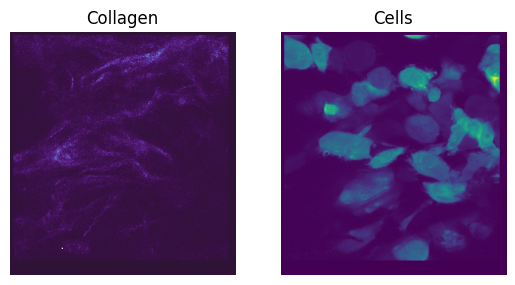

In [5]:
collagen_image = image_at_time[0,:,:,0]
cell_image = image_at_time[0,:,:,1]

plt.subplot(1,2,1)
plt.imshow(collagen_image, cmap='twilight_shifted')
plt.axis('off')
plt.title(f'Collagen')

plt.subplot(1,2,2)
plt.imshow(cell_image)
plt.axis('off')
plt.title(f'Cells')

Models require an API key to load, and are only available for non commercial purposes after logging into a DeepCell account

In [6]:
import os

key = 'POtyuCIN.nWwQ1FXgroiE8zKTWLgf5rdqGRJeKQHf'
os.environ.update({"DEEPCELL_ACCESS_TOKEN": key})

## Pick a model based on datatype

- If segmenting cytoplasm, use: [CytoplasmSegmentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#cytoplasmsegmentation)
- If segmenting nuclei, use: [NuclearSegmentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#nuclearsegmentation)
- If segmenting tissue, use: [Mesmer](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#mesmer)

For this example, we will opt to segment cytoplasm as the fluorescence image highlights whole cells

----

DeepCell also has a [cell tracking model](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#celltracking), a [label detecting model](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#labeldetectionmodel), and a [scale detecting model](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#scaledetectionmodel)

In [7]:
def load_all_deepcell():
    models = {
        'cyto' : CytoplasmSegmentation(),
        'nuclei' : NuclearSegmentation(),
        'tissue' : Mesmer()
    }

    return models

all_models = load_all_deepcell()

INFO:root:Checking for cached data
INFO:root:Checking NuclearSegmentation-75.tar.gz against provided file_hash...
INFO:root:NuclearSegmentation-75.tar.gz with hash efc4881db5bac23219b62486a4d877b3 already available.
INFO:root:Extracting C:\Users\aarus\.deepcell\models\NuclearSegmentation-75.tar.gz
INFO:root:Successfully extracted C:\Users\aarus\.deepcell\models\NuclearSegmentation-75.tar.gz into C:\Users\aarus\.deepcell\models


INFO:root:Checking for cached data
INFO:root:Checking MultiplexSegmentation-9.tar.gz against provided file_hash...
INFO:root:MultiplexSegmentation-9.tar.gz with hash a1dfbce2594f927b9112f23a0a1739e0 already available.
INFO:root:Extracting C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz
INFO:root:Successfully extracted C:\Users\aarus\.deepcell\models\MultiplexSegmentation-9.tar.gz into C:\Users\aarus\.deepcell\models


## Make a prediction on the example image

In [8]:
cyto = all_models['cyto']
img = np.expand_dims(cell_image, 0)
img = np.expand_dims(img, 3)
masks = cyto.predict(img)

INFO:root:Converting image dtype to float


Text(0.5, 1.0, 'Prediction')

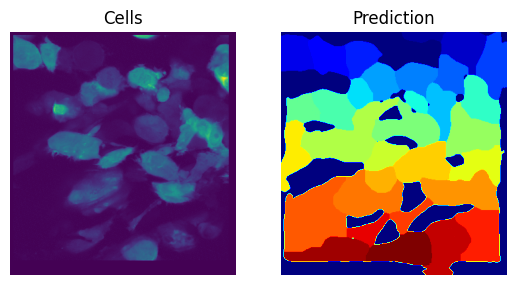

In [9]:
plt.subplot(1,2,1)
plt.imshow(cell_image)
plt.axis('off')
plt.title('Cells')

plt.subplot(1,2,2)
plt.imshow(np.squeeze(masks), cmap='jet')
plt.axis('off')
plt.title('Prediction')

## Try all models

Just as a proof of concept, displays results from all models

(Mesmer requires two channels rather than just the single channels models shown above)

INFO:root:Converting image dtype to float


INFO:root:Converting image dtype to float
INFO:root:Converting image dtype to float


Text(0.5, 1.0, 'tissue')

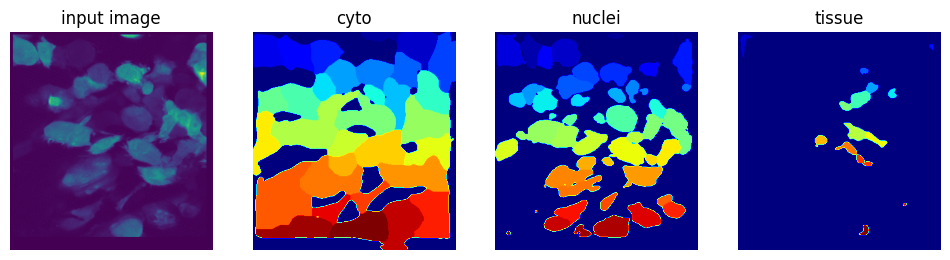

In [13]:
def display_deepcell(img, models):
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1, 4, 1)
    plt.imshow(np.squeeze(img))
    plt.axis("off")
    plt.title("input image")


    for i in range(2,4):
        model_name = list(models.keys())[i-2]
        model = models[model_name]
        masks = model.predict(img)
        plt.subplot(1, 4, i)
        plt.imshow(np.squeeze(masks), cmap='jet')
        plt.axis("off")
        plt.title(f"{model_name}")

display_deepcell(img, all_models)

masks = all_models['tissue'].predict(image_at_time)
plt.subplot(1, 4, 4)
plt.imshow(np.squeeze(masks), cmap='jet')
plt.axis("off")
plt.title(f"tissue")